### Importing Libraries

In [683]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce
import pprint 

### Loading Dataset

In [684]:
data = pd.read_csv("Threats.csv")
data.head()

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,40000,40001,0.012996,tcp,-,FIN,16,18,1540,1644,...,1,6,0,0,0,5,7,0,Normal,0
1,40001,40002,0.004119,tcp,-,FIN,12,12,1064,2260,...,1,1,0,0,0,3,8,0,Normal,0
2,40002,40003,0.000988,udp,dns,CON,2,2,146,178,...,1,2,0,0,0,7,2,0,Normal,0
3,40003,40004,3.415787,tcp,ssh,FIN,230,238,24344,29556,...,1,1,0,0,0,4,1,0,Normal,0
4,40004,40005,0.193943,tcp,-,FIN,72,74,4238,63618,...,1,5,0,0,0,6,12,0,Normal,0


### Cleaning The Dataset

In [685]:
data = data.drop(["Unnamed: 0", "id"], axis=1)
data = data.dropna()
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.012996,tcp,-,FIN,16,18,1540,1644,2539.242797,31,...,1,6,0,0,0,5,7,0,Normal,0
1,0.004119,tcp,-,FIN,12,12,1064,2260,5583.879675,31,...,1,1,0,0,0,3,8,0,Normal,0
2,0.000988,udp,dns,CON,2,2,146,178,3036.437382,31,...,1,2,0,0,0,7,2,0,Normal,0
3,3.415787,tcp,ssh,FIN,230,238,24344,29556,136.718127,31,...,1,1,0,0,0,4,1,0,Normal,0
4,0.193943,tcp,-,FIN,72,74,4238,63618,747.642372,31,...,1,5,0,0,0,6,12,0,Normal,0


### Visualizing The `Attack Categories`

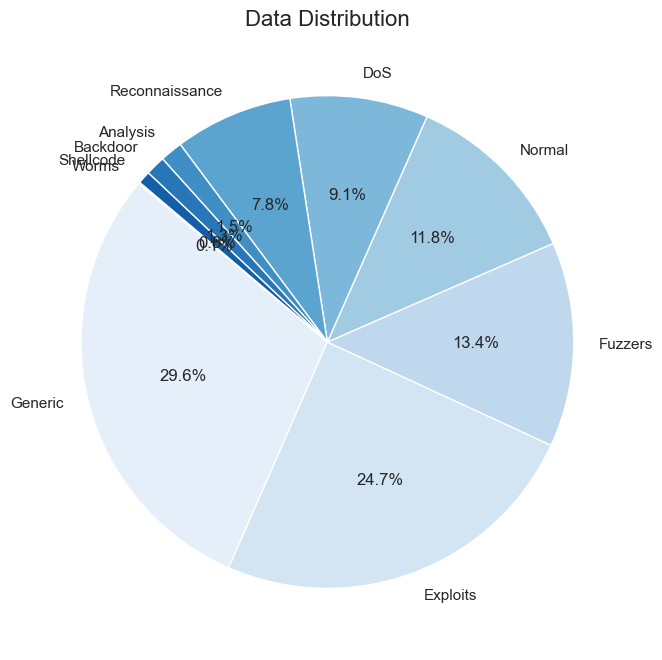

In [686]:
# Count the occurrences of each attack category
attack_counts = data['attack_cat'].value_counts()

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("Blues", len(attack_counts))  # Use Seaborn's blue color palette
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)

# Add a title
plt.title('Data Distribution', fontsize=16)

# Show the plot
plt.show()

From the `data distribution`, we observe that attack categories such as `Worms`, `Shellcode`, `Backdoor`, and others have a very small number of instances. As a result, we can expect the model to struggle in accurately predicting these less frequent attack types.

### Getting The Correlation Matrix

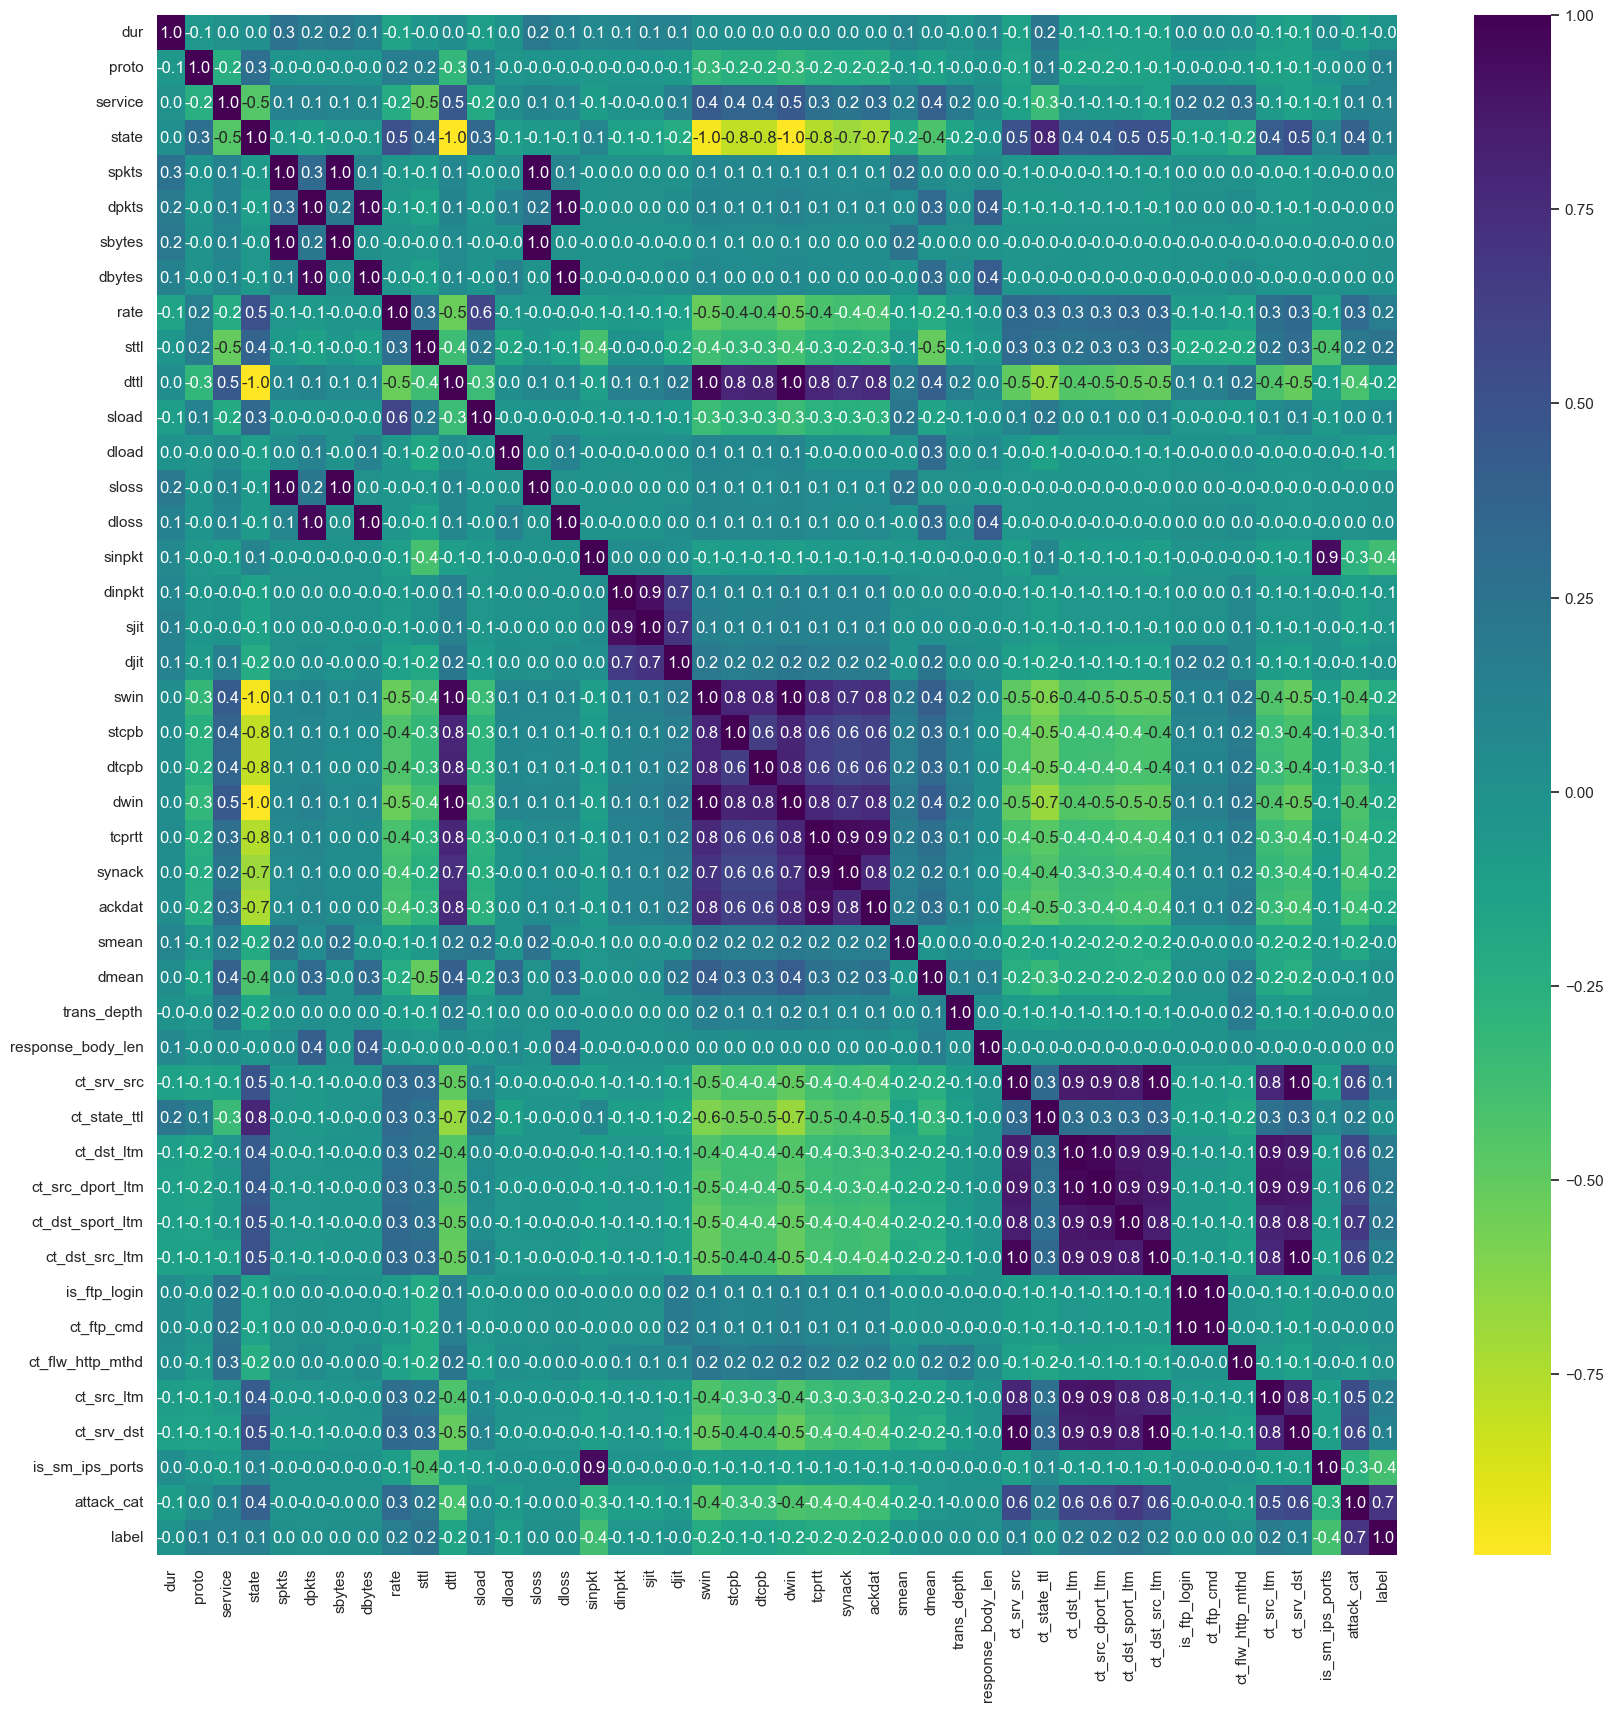

In [687]:
encoder = ce.OrdinalEncoder(cols=['proto', 'service', 'state', 'attack_cat']) # Converting the categorical variables into numerical features
data_encoded = encoder.fit_transform(data)
corr = data_encoded.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='viridis_r',annot=True, fmt=".1f")
plt.show()

### Finding Relevant Features (Removing Features With Lower Correlation)

In [688]:
cor_target = abs(corr["attack_cat"])

relevant_features = cor_target[cor_target>0.1] #Selecting relevant features by removing the ones with very low correlation

# Collect the features
features = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
features.remove('attack_cat')
features.remove('label')
# Display the results
pprint.pprint(features)

['service',
 'state',
 'rate',
 'sttl',
 'dttl',
 'sinpkt',
 'dinpkt',
 'sjit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']


In [689]:
X = data[features]
y = data['attack_cat']

### Splitting Dataset Into Training and Testing Datasets

In [690]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27) #Splitting quarter of the dataset to test on it


In [691]:
X_train.dtypes

service              object
state                object
rate                float64
sttl                  int64
dttl                  int64
sinpkt              float64
dinpkt              float64
sjit                float64
swin                  int64
stcpb                 int64
dtcpb                 int64
dwin                  int64
tcprtt              float64
synack              float64
ackdat              float64
smean                 int64
ct_srv_src            int64
ct_state_ttl          int64
ct_dst_ltm            int64
ct_src_dport_ltm      int64
ct_dst_sport_ltm      int64
ct_dst_src_ltm        int64
ct_src_ltm            int64
ct_srv_dst            int64
is_sm_ips_ports       int64
dtype: object

### Encoding Categorical Variables By Creating An Ordinal Encoder

In [692]:
encoder = ce.OrdinalEncoder(cols=['service', 'state'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

X_train.head()

,service,state,rate,sttl,dttl,sinpkt,dinpkt,sjit,swin,stcpb,...,smean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
128005,1,1,1.060597,254,0,954.815563,0.000,1174.328750,0,0,...,272,2,6,3,2,2,5,3,2,0
94592,1,2,19.304164,254,252,94.941222,109.995,6214.550284,255,1620553860,...,56,1,1,1,1,1,1,2,1,0
109919,2,3,500000.001300,254,0,0.002000,0.000,0.000000,0,0,...,57,24,2,24,24,15,24,24,24,0
81838,2,3,333333.321500,254,0,0.003000,0.000,0.000000,0,0,...,57,34,2,6,6,6,34,6,34,0
8048,1,3,125000.000300,254,0,0.008000,0.000,0.000000,0,0,...,100,4,2,1,1,1,4,3,4,0


### Implementing The Model Using `sklearn`

In [693]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier( max_depth=14, random_state=27) # max depth of 14 gives the higest accuracy
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Printing Accuracy Metrics

In [694]:
from sklearn.metrics import f1_score, matthews_corrcoef, recall_score

f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted for multiclass
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted for multiclass

# Display Results
print(f"F1 Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")
print(f"Recall Rate: {recall:.2f}")

F1 Score: 0.74
Matthews Correlation Coefficient (MCC): 0.70
Recall Rate: 0.76


### Printing Classification Report

In [695]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      Analysis       0.59      0.13      0.21       525
      Backdoor       0.57      0.09      0.16       468
           DoS       0.35      0.15      0.21      2992
      Exploits       0.62      0.89      0.73      8288
       Fuzzers       0.69      0.75      0.72      4633
       Generic       1.00      0.98      0.99      9983
        Normal       0.77      0.63      0.69      3981
Reconnaissance       0.92      0.76      0.83      2635
     Shellcode       0.63      0.53      0.58       298
         Worms       0.50      0.48      0.49        33

      accuracy                           0.76     33836
     macro avg       0.66      0.54      0.56     33836
  weighted avg       0.76      0.76      0.74     33836



The `classification report` shows that the accuracy metrics for the categories with very few instances in the dataset are significantly low. This suggests that the model was unable to learn effectively for these categories due to the limited amount of training data available for these particular categories

### Printing Confusion Matrix

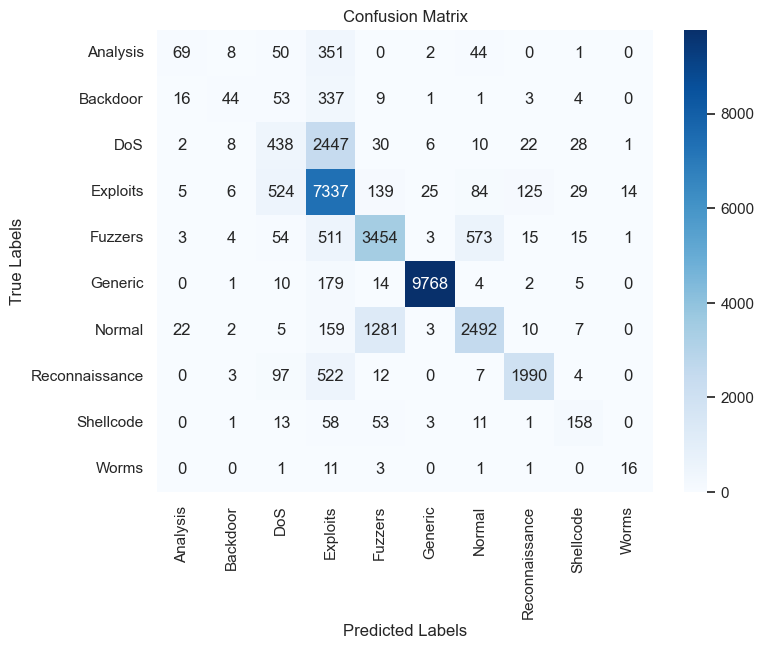

In [696]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = y_test.unique()
class_names = sorted(class_names)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()